## 1st Midterm(2024) - Assignment 7 - Alice Nicoletta
"Implement the convolution of a Laplacian of a Gaussian blob (LoG) detector with an image and apply it to 3-4 images of your choice from the dataset. Do not use library functions for implementing the convolution or to generate the LoG filter. Implement your own and show the code (the interesting bits at least)! The function you implement should be able to run the LoG for different choices of the scale parameter, which is passed as an input argument. Show the results of your code on the 3-4 example images, for different choices of the scale parameter (sigma)."

In [2]:
import numpy as np
import cv2 # OpenCV
import matplotlib.pyplot as plt
import seaborn as sns

img = cv2.imread('./weizmann_horse_db/horse/horse001.png', cv2.IMREAD_GRAYSCALE)

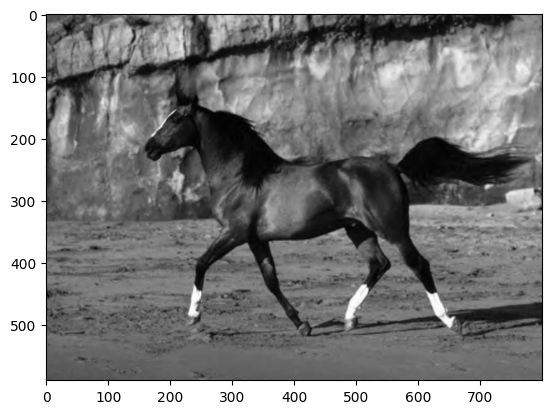

In [8]:
plt.imshow(img, cmap='gray')
plt.show()

Let's implement the convolution function between image and kernel.

In [538]:
#convolution
def convolution(img, kernel) -> np.ndarray:
    h1, w1 = img.shape
    h2, w2 = kernel.shape

    img = np.pad(img, (h2//2, w2//2), 'constant')

    conv_img = np.zeros((h1, w1))
    for i in range(h1):
        for j in range(w1):
            conv_img[i,j] = (img[i:i+h2 , j:j+w2] * kernel).sum()
    return conv_img


Let's now implement the Laplacian of Gaussian, through this formula:
$$\nabla^2 g_\sigma(x,y)=\frac{\partial^2 g_\sigma}{\partial^2 x}+\frac{\partial^2 g_\sigma}{\partial^2 y}=\frac{1}{\pi \sigma^4}(\frac{x^2+y^2}{\sigma^2}-1)e^{-\frac{x^2+y^2}{2\sigma^2}}$$
and we normalize it by multypling by $\sigma^2$.

In [353]:
def lapl(x,y,sigma):  #function just to calculate the laplacian of gaussian on each entry
    a = (x**2 + y**2) / (2*sigma**2)
    b=np.pi*sigma**2
    return (a - 1)*np.exp(-a)/b

#Laplacian of Gaussian
def LoG(sz, sigma) -> np.ndarray:
    kernel=np.zeros((sz,sz))
    for i in range(sz):
        for j in range(sz):
            kernel[i,j] = lapl(i-sz//2,j-sz//2,sigma)
    return kernel

We can test the LoG function with a plot of a kernel of size 21 and $\sigma=2$.

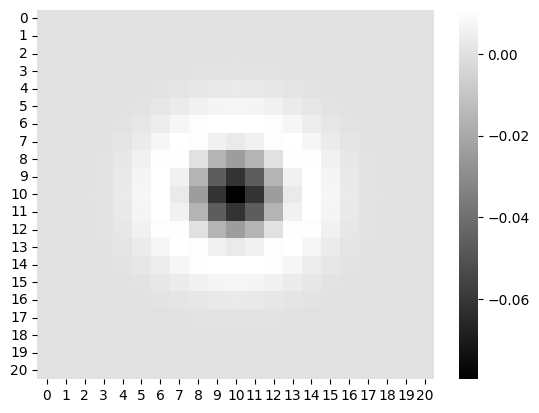

In [522]:
A=LoG(21,2)
sns.heatmap(A, cmap='gray')
plt.show()

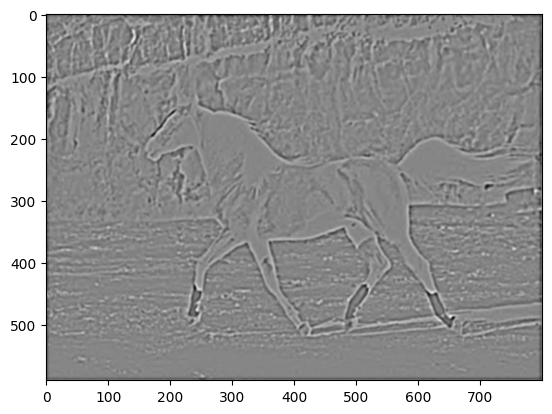

In [523]:
img = cv2.imread('./weizmann_horse_db/horse/horse001.png', cv2.IMREAD_GRAYSCALE)
modd=convolution(img, A)
plt.imshow(modd, cmap='gray')
plt.show()

The LoG and convolution functions seem to work as intended, since it recognizes the edges in the image.

# Blob Detection

The naive way to solve the blob detection task would be to find some maxima on the each space-scale (so a 3-dimensional maximum problem) and then threshold by the value of the squared LoG response: 
$$(x^*,y^*,\sigma^*)=\underset{x,y,\sigma}{\text{argmax}} \:[\nabla^2_\sigma g\ast I (x,y)]^2$$
Then, knowning that  the filter has maximum response when centered on a circle of radius $\sqrt{2}\sigma$, we can draw each circle of radius $\sqrt{2}\sigma^*$ centered in $(x^*,y^*)$.

However, by doing this we would catch too many blobs in the same area with similar response, so later we define a grid to avoid this.

Let's now define a function to create various scale spaces by changing the $\sigma$.

In [502]:
def generate_scale_space(img , scales , kernel_size) -> np.ndarray:
    b=(img.shape[0],img.shape[1],scales.size)
    a=np.zeros(b) #the tensor in which we collect our scale spaces.
    for i in range(scales.size):
        kernel=LoG(kernel_size,scales[i])
        conv_img=convolution(img,kernel)
        a[:,:,i]=conv_img
      

    return a


Now we define a function to draw circles in the coordinates and with the radius=$\sqrt{2}\sigma$.

In [619]:
from matplotlib.patches import Circle
def draw_circ(coords,scales,threshold):    
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    for blob in coords:
        circ = Circle((blob[1], blob[0]),np.sqrt(2)*scales[blob[2]], fill=False, color='red')
        ax.add_patch(circ)
    fig.suptitle(f'Threshold= {threshold}')
    ax.imshow(img, cmap='gray')
    plt.show()

Now we can use this function "grid" to create a grid of $n\times n\times$ number-of-scales "cubes" (n=grid_size) in the image and find a maximum for each cube. This is a simple (but not very accurate) way to discretize and avoid too much overlapping among detected blobs. The coordinates (and the $\sigma$) are saved in the coords matrix.

In [332]:
def grid(A, grid_size)->np.ndarray:
    count=0
    X=np.arange(grid_size,A.shape[0],grid_size)
    Y=np.arange(grid_size,A.shape[1],grid_size)
    n_blobs=X.shape[0]*Y.shape[0]
    coords=np.zeros((n_blobs,3))
    for i in X[:-1]:
        for j in Y[:-1]:
            argmx=A[i-grid_size:i , j-grid_size:j , :].argmax()
            coords[count,:]=np.unravel_index(argmx, (grid_size, grid_size , A.shape[2]))
            coords[count,0]=coords[count,0]+i
            coords[count,1]=coords[count,1]+j
            count=count+1
    return coords


## First image

In [633]:
img = cv2.imread('./weizmann_horse_db/horse/horse012.png', cv2.IMREAD_GRAYSCALE)
import math
sigma_start=1
sigma_end=10
sigma_step=1
#kernel_size=math.floor(2*np.sqrt(2)*sigma_end+10)
#scale_vec = np.arange(sigma_start, sigma_end, sigma_step)
kernel_size=15
scale_vec=np.array([2,3,4])
a=generate_scale_space(img=img/255,
    scales=scale_vec,
    kernel_size=kernel_size,
     )

In [634]:
a=np.absolute(a)
blobs=grid(a,5)
blobs=blobs.astype(int)
blobs.dtype

dtype('int32')

In [640]:
threshold=0.3
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])

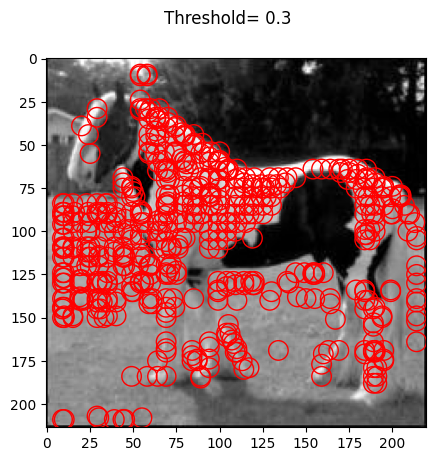

In [641]:
draw_circ(blobs_thr,scale_vec,threshold)

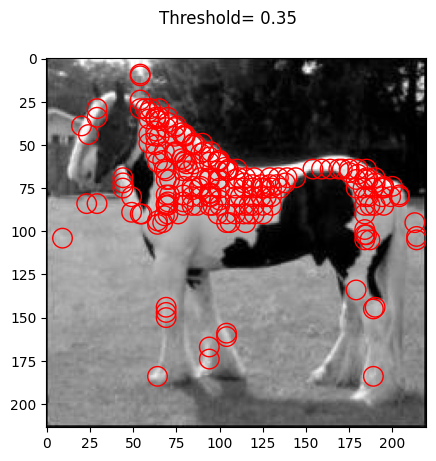

In [643]:
threshold=0.35
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])
draw_circ(blobs_thr,scale_vec,threshold)

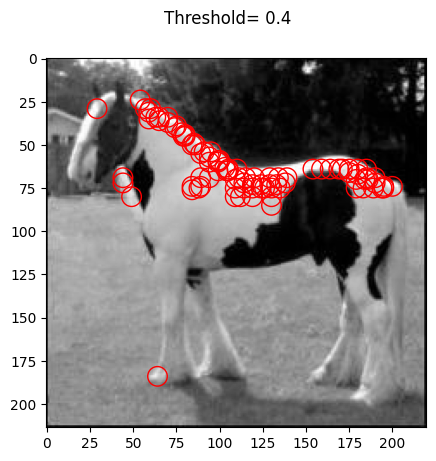

In [644]:
threshold=0.4
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])
draw_circ(blobs_thr,scale_vec,threshold)

The algorithm detects well the white parts of the horse and goes around his shape and also around his black patches.

## Second Image

In [622]:
img = cv2.imread('./weizmann_horse_db/horse/horse204.png', cv2.IMREAD_GRAYSCALE)
import math
sigma_start=1
sigma_end=17
sigma_step=4
#kernel_size=math.floor(2*np.sqrt(2)*sigma_end+10)

#scale_vec = np.arange(sigma_start, sigma_end, sigma_step)
#scale_vec=np.array([])
kernel_size=45
scale_vec=np.array([4,6,8,12])
a=generate_scale_space(img=img/255,
    scales=scale_vec,
    kernel_size=kernel_size,
     )
a=np.absolute(a)
blobs=grid(a,15)
blobs=blobs.astype(int)



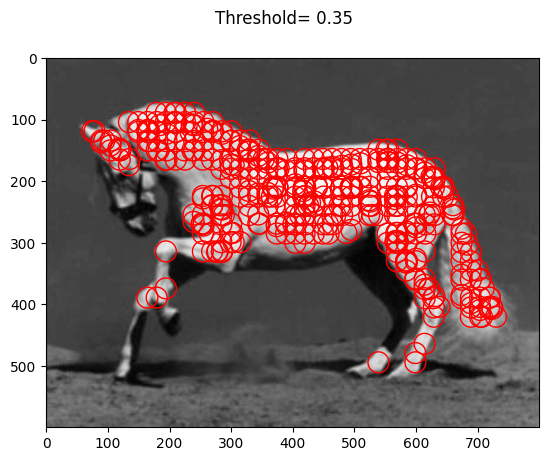

In [623]:
threshold=0.35
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])
len(blobs_thr)
draw_circ(blobs_thr,scale_vec,threshold)

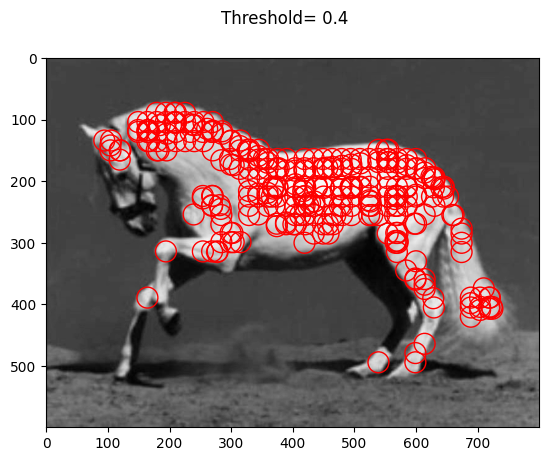

In [624]:
threshold=0.4
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])
len(blobs_thr)
draw_circ(blobs_thr,scale_vec,threshold)

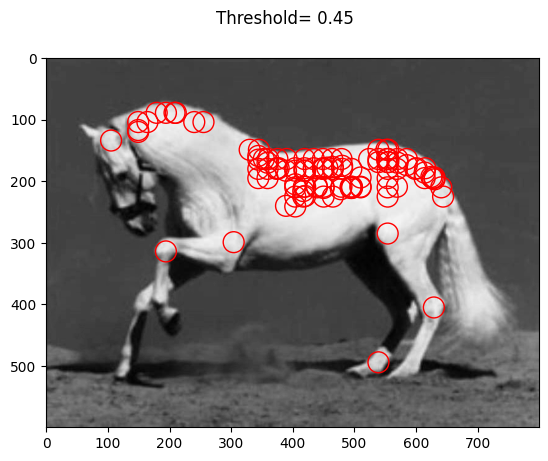

In [625]:
threshold=0.45
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])
len(blobs_thr)
draw_circ(blobs_thr,scale_vec,threshold)

## Third Image

In [626]:
img = cv2.imread('./weizmann_horse_db/horse/horse215.png', cv2.IMREAD_GRAYSCALE)
import math
sigma_start=1
sigma_end=17
sigma_step=4
#kernel_size=math.floor(2*np.sqrt(2)*sigma_end+10)

#scale_vec = np.arange(sigma_start, sigma_end, sigma_step)
#scale_vec=np.array([0.5])
scale_vec=np.array([4,6,8])
kernel_size=30
a=generate_scale_space(img=img/255,
    scales=scale_vec,
    kernel_size=kernel_size,
     )
a=np.absolute(a)
blobs=grid(a,10)
blobs=blobs.astype(int)

In [627]:
threshold=0.3
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])
len(blobs_thr)

178

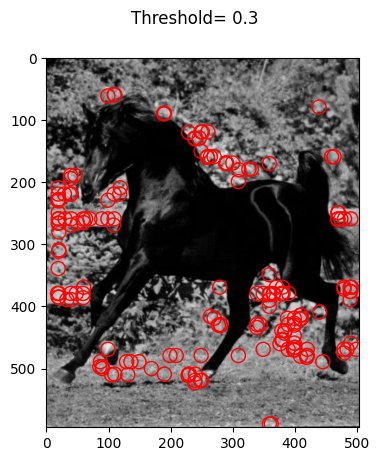

In [628]:
draw_circ(blobs_thr,scale_vec,threshold)

As we can see, we cannot really catch dark areas. So we can try to use $1-image$ in the convolution.

In [629]:
img = cv2.imread('./weizmann_horse_db/horse/horse215.png', cv2.IMREAD_GRAYSCALE)
import math
sigma_start=1
sigma_end=17
sigma_step=4
#kernel_size=math.floor(2*np.sqrt(2)*sigma_end+10)

#scale_vec = np.arange(sigma_start, sigma_end, sigma_step)
#scale_vec=np.array([0.5])
scale_vec=np.array([4,6,8])
kernel_size=30
a=generate_scale_space(img=1-img/255,
    scales=scale_vec,
    kernel_size=kernel_size,
     )
a=np.absolute(a)
blobs=grid(a,10)
blobs=blobs.astype(int)

In [630]:
threshold=0.4
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])
len(blobs_thr)

911

Now the model can indeed catch dark blobs. 

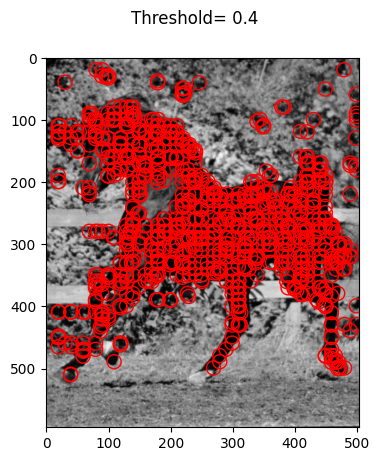

In [631]:
draw_circ(blobs_thr,scale_vec,threshold)

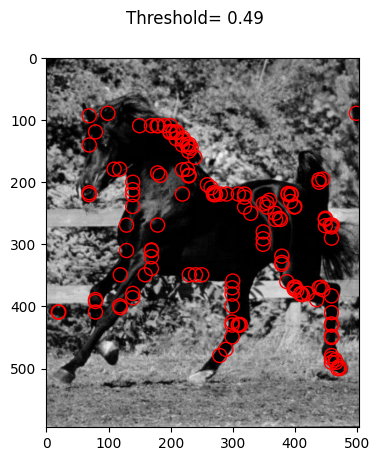

In [632]:
threshold=0.49
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])
len(blobs_thr)
draw_circ(blobs_thr,scale_vec,threshold)

We managed to catch the horse's legs.

## 4th Image

We do the same for this image, by trying to detect the dark patches on the horse coat.

In [646]:
img = cv2.imread('./weizmann_horse_db/horse/horse282.png', cv2.IMREAD_GRAYSCALE)
import math
sigma_start=1
sigma_end=17
sigma_step=4
#kernel_size=math.floor(2*np.sqrt(2)*sigma_end+10)

#scale_vec = np.arange(sigma_start, sigma_end, sigma_step)
#scale_vec=np.array([0.5])
scale_vec=np.array([1,2,3,4,5,6])
kernel_size=25
a=generate_scale_space(img=1-img/255,
    scales=scale_vec,
    kernel_size=kernel_size,
     )
a=np.absolute(a)
blobs=grid(a,10)
blobs=blobs.astype(int)

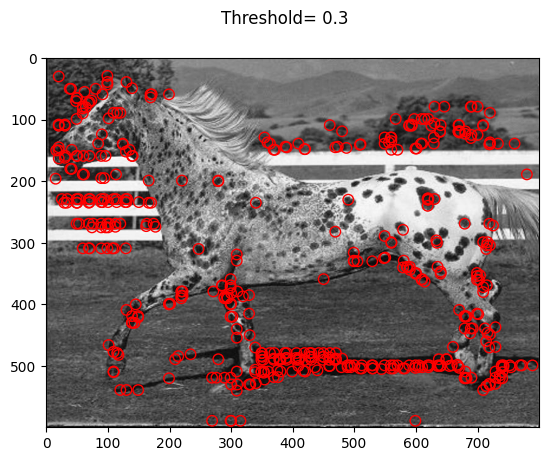

In [647]:
threshold=0.3
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])

draw_circ(blobs_thr,scale_vec,threshold)

Let's try to catch the patches on the horse with smaller values of $\sigma$.

In [652]:
img = cv2.imread('./weizmann_horse_db/horse/horse282.png', cv2.IMREAD_GRAYSCALE)
import math
scale_vec=np.array([2, 2.5, 3, 3.5, 4])
kernel_size=17
a=generate_scale_space(img=1-img/255,
    scales=scale_vec,
    kernel_size=kernel_size,
     )
a=np.absolute(a)
blobs=grid(a,10)
blobs=blobs.astype(int)

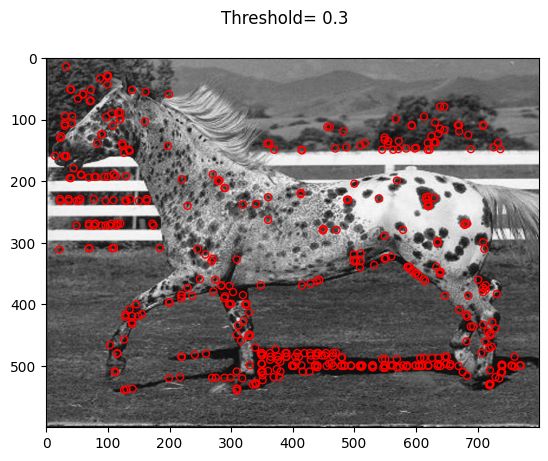

In [653]:
threshold=0.3
blobs_thr=[]
for i in range(blobs.shape[0]):
    if a[blobs[i,0],blobs[i,1],blobs[i,2]]>threshold:
        blobs_thr.append(blobs[i,:])

draw_circ(blobs_thr,scale_vec,threshold)

We had some improvements, but it's still hard to detect the patches as they are of different sizes.

# Conclusions
The model indeed works properly, as it recognizes the edges and is able to mainly catch the horses instead more than the background and it also highlights some features of the animal, like the back, legs and coat patches.

The code could be polished by improving the way maxima are chosen to further avoid overlap between blobs and automatizing a bit more the choice of parameters like sigma, grid_size and kernel size, which was done mostly by hand here.

Major limitations are also the algorithm working only on grayscale and the restriction to mainly circular-shaped areas.

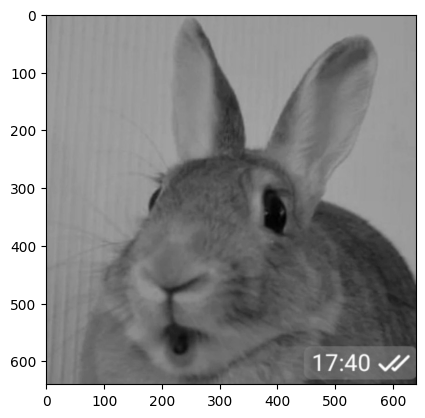

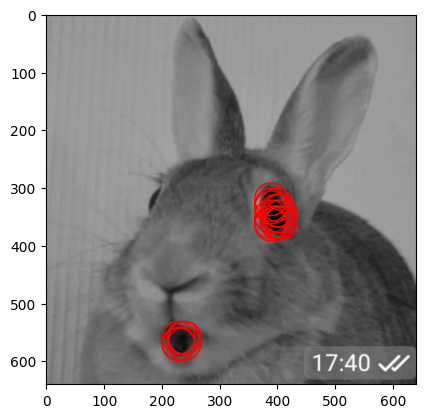

In [588]:
plt.imshow(img, cmap='gray')
draw_circ(blobs_thr,scale_vec)